<a href="https://colab.research.google.com/github/shalini1291/tweets_depression_detect/blob/main/tweets_depression_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re

In [3]:
data = pd.read_csv("/content/sentiment_tweets3.csv")

In [4]:
data.shape

(10314, 3)

In [5]:
# Check the data
data.head(10)

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [6]:
#Removing the Unnamed: 0 (we will only use the message)
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [8]:
# Convert to lowercase
data['message'] = data['message'].apply(lambda x: x.lower())
data.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat need to send 'em to my accountant tomo...,0
4,add me on myspace!!! myspace.com/lookthunder,0


In [9]:
# Remove punctuation

import string

def punctuation_removal(message):
    all_list = [char for char in message if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['message'] = data['message'].apply(punctuation_removal)

In [10]:
#Created a function to remove the extra space, chr. special, ulr and links.
def wordopt(message):
    text = re.sub('\[.*?\]', '', message)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', message)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', message)
    text = re.sub('\n', '', message)
    text = re.sub('\w*\d\w*', '', message)
    return message

In [11]:
data["message"] = data["message"].apply(wordopt)

In [12]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['message'] = data['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
data.head()

,message,label
0,real good moment missssssssss much,0
1,reading manga httpplurkcompmzp1e,0
2,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...,0
3,lapcat need send em accountant tomorrow oddly ...,0
4,add myspace myspacecomlookthunder,0


label
0    8000
1    2314
Name: message, dtype: int64


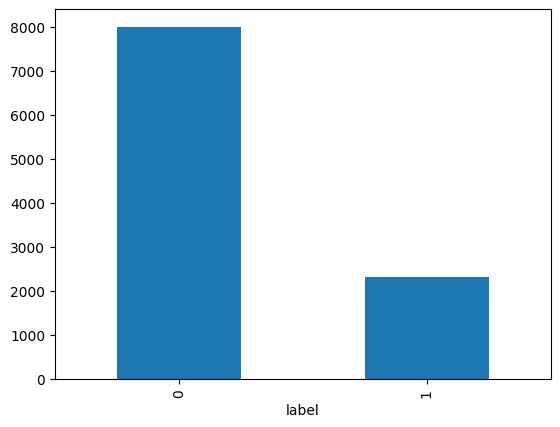

In [14]:
# How many depressed '1' and not depressed '0' ?
print(data.groupby(['label'])['message'].count())
data.groupby(['label'])['message'].count().plot(kind="bar")
plt.show()

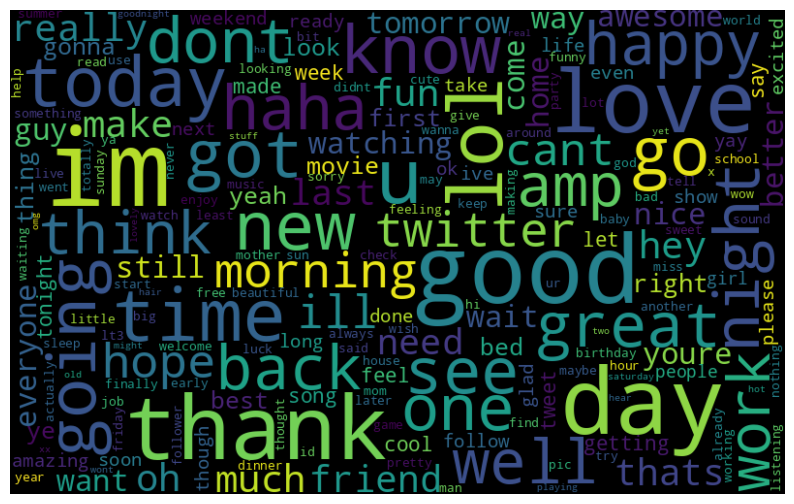

In [15]:
# Word cloud for not Depressed
from wordcloud import WordCloud

sentiment_data = data[data["label"] == 0]
all_words = ' '.join([message for message in sentiment_data.message])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

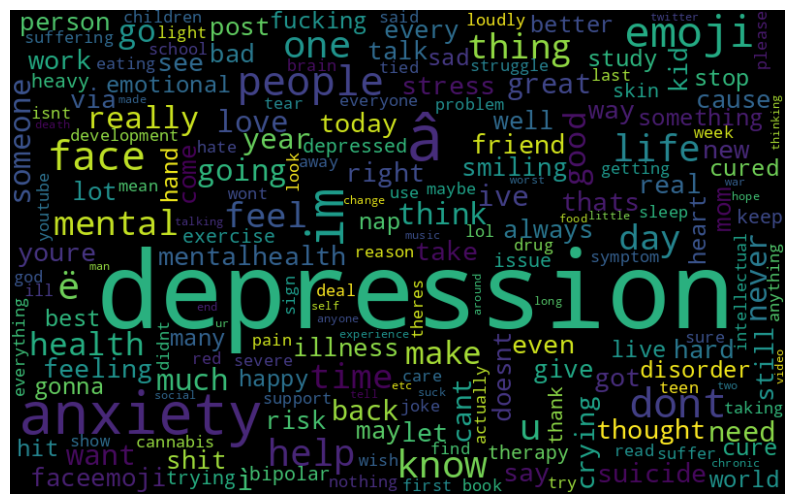

In [16]:
# Depression Tweets
from wordcloud import WordCloud

depression_data = data[data["label"] == 1]
all_words = ' '.join([message for message in depression_data.message])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(message, column_text, quantity):
    all_words = ' '.join([message for message in message[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

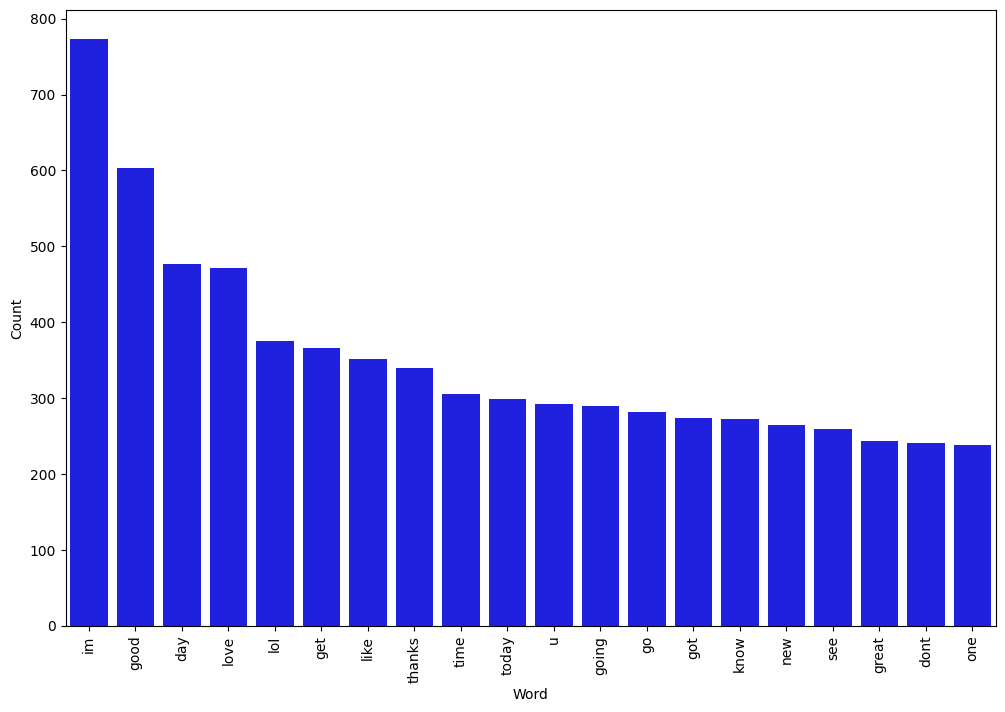

In [18]:
# Most frequent words in not Depressed
counter(data[data["label"] == 0], "message", 20)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


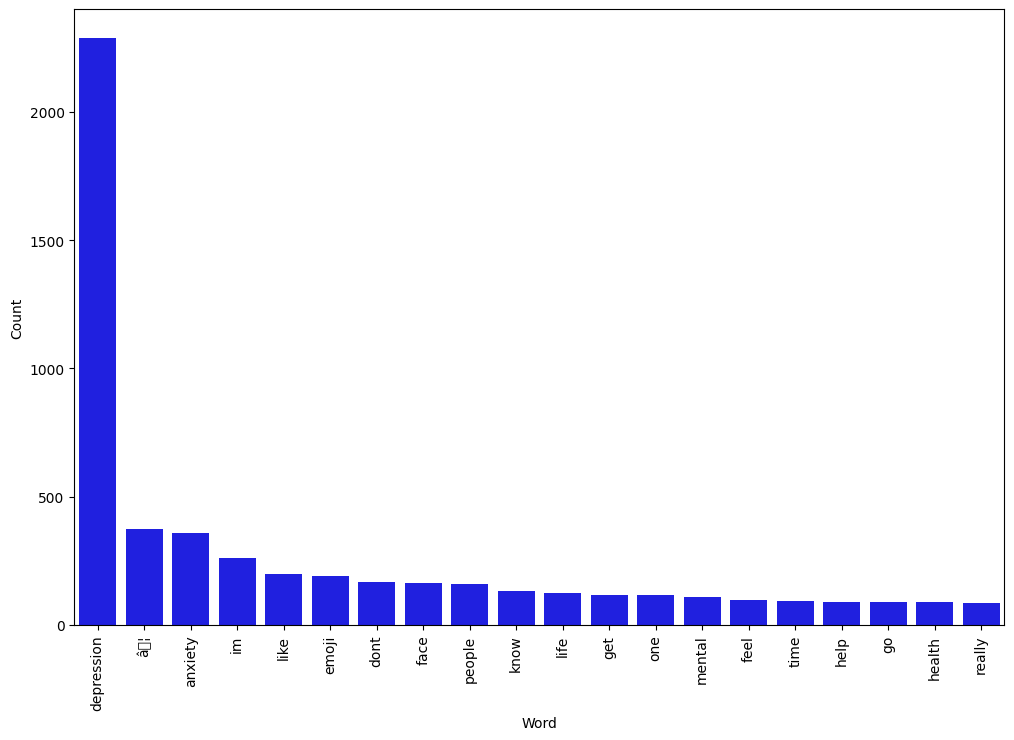

In [19]:
# Most frequent words in Depressed
counter(data[data["label"] == 1], "message", 20)

In [20]:
# Function to plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
#Define dependent and independent variable as x and y
x = data["message"]
y = data["label"]

In [22]:
#Divide the dataset into training set and test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [23]:
#Convert text to vectors
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
#vectorizer = CountVectorizer(decode_error = 'replace')

In [25]:
vectorizer = TfidfVectorizer()
xv_train = vectorizer.fit_transform(x_train)
xv_test = vectorizer.transform(x_test)

In [26]:
import pickle

pickle.dump(vectorizer.vocabulary_, open("tfidf.pickle", "wb"))

In [27]:
vectorizer.get_feature_names_out()

array(['00', '007peter', '033654', ..., 'ÿä', 'šà', 'žã'], dtype=object)

In [28]:
xv_train

<7735x19097 sparse matrix of type '<class 'numpy.float64'>'
	with 66925 stored elements in Compressed Sparse Row format>

In [29]:
xv_test.shape

(2579, 19097)

In [30]:
xv_train.shape

(7735, 19097)

In [31]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

In [32]:
RFC = RandomForestClassifier()
temp = RFC.fit(xv_train, y_train)

In [33]:
pred_rfc = RFC.predict(xv_test)

In [34]:
RFC.score(xv_test, y_test)

0.931756494765413

Confusion matrix, without normalization


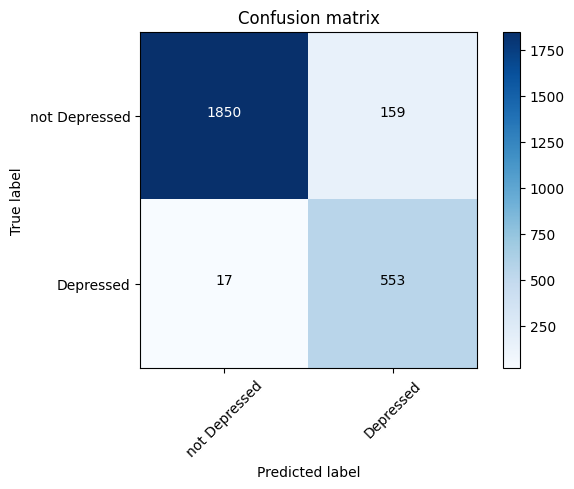

In [35]:
cm = metrics.confusion_matrix(y_test, pred_rfc)
plot_confusion_matrix(cm, classes=['not Depressed', 'Depressed'])

In [36]:
def output_lable(n):
    if n == 0:
        return "not Depressed"
    elif n == 1:
        return "Depressed"

def manual_testing(msgs):
    testing_msgs = {"message":[msgs]}
    msg_def_test = pd.DataFrame(testing_msgs)
    msg_def_test["message"] = msg_def_test["message"].apply(wordopt)
    msg_x_test = msg_def_test["message"]
    msg_xv_test = vectorizer.transform(msg_x_test)
    pred_RFC = RFC.predict(msg_xv_test)

    return print(output_lable(pred_RFC[0]))

In [37]:
message = str(input())
manual_testing(message)

angry
Depressed


In [38]:
message = str(input())
manual_testing(message)

hi
not Depressed


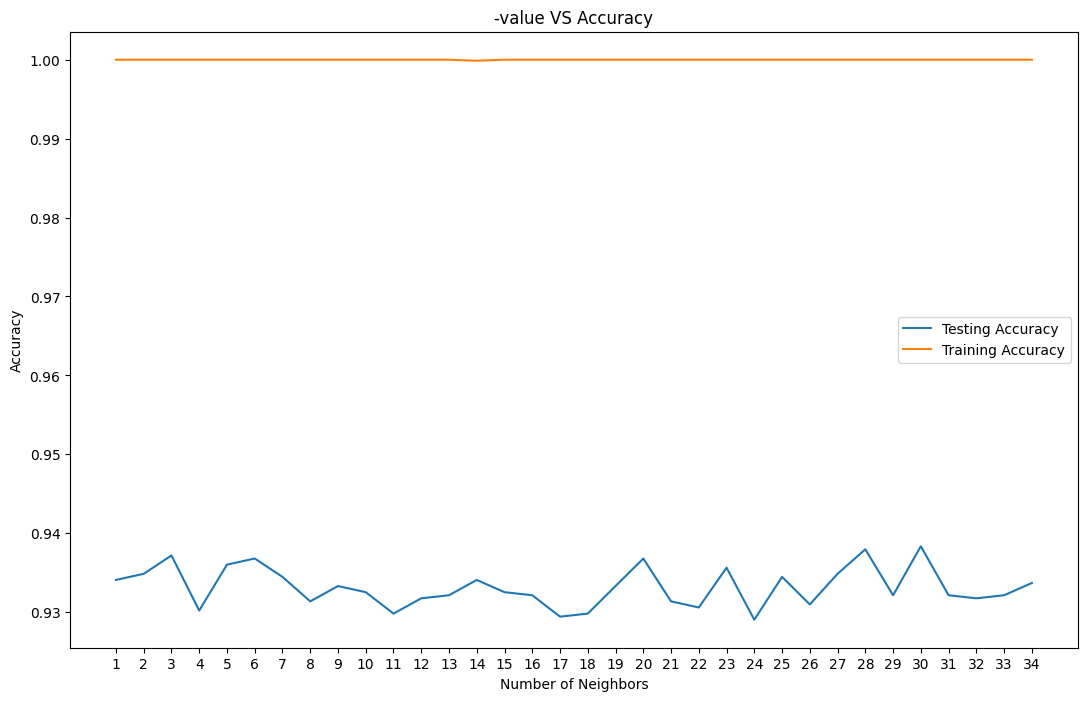

Best accuracy is 0.9383481969755719 with K = 30


In [39]:
neig = np.arange(1, 35)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):

    RFC = RandomForestClassifier()
    RFC.fit(xv_train, y_train)
    #train accuracy
    train_accuracy.append(RFC.score(xv_train, y_train))
    # test accuracy
    test_accuracy.append(RFC.score(xv_test, y_test))

# Plot
plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))